## Adiabatic parameters from neutron's paths
Emma Klemets   
Nov. 2022   
Full documentation of the theory can be found at: https://www.overleaf.com/read/rfkkhhwwfjct

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy.constants as const
from numpy import linalg as LA
import pandas as pd

In [2]:
#importing physical constants that are useful from scipy.constants
m_p = const.physical_constants['proton mass energy equivalent in MeV'][0]
m_n = const.physical_constants['neutron mass energy equivalent in MeV'][0]
c = const.c #m/s
hbar = const.hbar

mu_n = const.physical_constants['neutron mag. mom.'][0] #J T^-1
g_n = const.physical_constants['neutron mag. mom. to nuclear magneton ratio'][0]
gamma_n = const.physical_constants['neutron gyromag. ratio'][0] #s^-1 T^-1, negative

In [7]:
#3.11 in Pierre
def K_equ_dbdt(B, dbdt):
    return gamma_n*B**2 / dbdt

#equation 2 in the CDR - Sect 4.1 for the value of k
#3.12 in Pierre
def K_equ_dbdx(B, db_perpdx, v_n):
    return gamma_n*B**2 / (v_n*db_perpdx)

#3.14 in Pierre
def K_equ3_14(v_vec, B_1, B_2, r_1, r_2):
    #what to use for this value of the field?
    B = LA.norm(B_1)
    
    v_n = LA.norm(v_vec)
    B_1_norm = LA.norm(B_1)
    B_2_norm = LA.norm(B_2)
    
    #the angle that the field changes by
    if B_1_norm == 0 or B_2_norm == 0: # if either 0 feild == bad, k=0
        k = 0
    elif B_1_norm*B_2_norm == 0:  #not so sure about this one
        '''
        if either norm is 0, then bad
        '''
#         print(B_1_norm, B_2_norm)
        k = 0 #-np.inf
    else:
        theta = np.arccos(B_1@B_2/(B_1_norm*B_2_norm))
    
        #the distance for that change
        delta_distance = LA.norm(r_2 - r_1)

        #k calculation
        k = gamma_n*B*delta_distance / (v_n * theta)

    return k

[11-10 8:41 a.m.] Jeffery W. Martin
Also, just to set a scale for this problem:

[11-10 8:42 a.m.] Jeffery W. Martin
Let's say the UCN moves in a straight line at 8 m/s.

[11-10 8:42 a.m.] Jeffery W. Martin
Let's say the magnetic field rotates by 90 degrees during this time.

[11-10 8:43 a.m.] Jeffery W. Martin
Actually, let's say it rotates by 90 degrees in the course of 1 m of travel by the neutron.

[11-10 8:43 a.m.] Jeffery W. Martin
And let's say the value of the field is typically 1 mT.

[11-10 8:43 a.m.] Jeffery W. Martin
For this situation, I get k=15,000



In [27]:
#trying out Jeff's numbers, matches up
v_vec = np.array([8, 0, 0]) #m/s

B_1 = np.array([1, 0, 0])*1e-6 #=1uT
B_2 = np.array([0, 1, 0])*1e-6 #=1uT
r_1 = np.array([0, 0, 0]) 
r_2 = np.array([1, 0, 0]) #dx = 1m

K_equ3_14(v_vec, B_1, B_2, r_1, r_2)

14.582346536127906

In [21]:
#calculates the k value for a 90 degrees turn with a uniform magnitude magnetic field (B)
#for a given neutron speed (vn) and distance of the turn (dx) 
def pseudoScalar_K_equ3_14(vn, B, dx):
    
    v_vec = np.array([vn, 0, 0])
    B_1 = np.array([B, 0, 0])
    B_2 = np.array([0, B, 0])
    r_1 = np.array([0, 0, 0]) 
    r_2 = np.array([dx, 0, 0])

    return K_equ3_14(v_vec, B_1, B_2, r_1, r_2)

In [129]:
#scalar imputs for simplicity
#speed of your neutrons
vn = 8 #/ms
#magnitude of your magnetic field
B = 500*1e-6
#distance travels during the turn
dx = .2

pseudoScalar_K_equ3_14(vn, B, dx)

1458.234653612791

In [168]:
n = 100
B_arr = np.linspace(1e-6, 500e-6, n)
dx_arr = np.linspace(.01, .55, n)

k_array = np.empty((0, 3))
for B in B_arr:
    for dx in dx_arr:
        val = pseudoScalar_K_equ3_14(vn, B, dx)
        k_array = np.append(k_array, np.array([[B, dx, val]]), axis=0)
        
# print(k_array)

In [169]:
df = pd.DataFrame(k_array, columns = ['B','dx','k'])
df = df.pivot("B", "dx", "k")

df = df.reindex(index=df.index[::-1])
# df

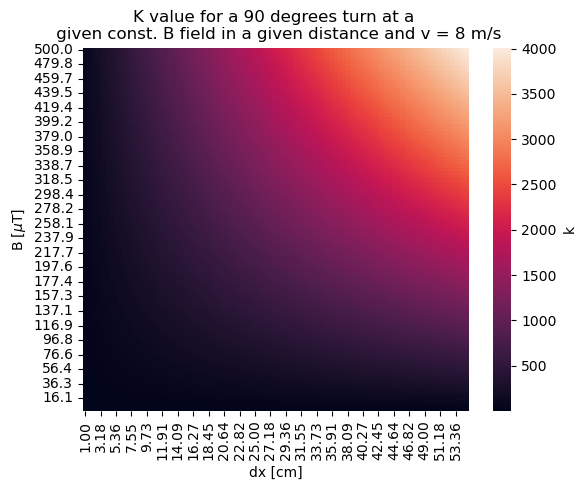

In [172]:
fig, ax = plt.subplots(figsize=(6, 5))
q = sns.heatmap(df)#xticklabels=10, yticklabels=10, cmap=new_purple, linewidths=0, square=True)
    
ax.collections[0].colorbar.set_label("k")

# Add axis tick labels
# ax.set_xticks(np.arange(len(df.columns)), 
#               labels=np.round(df.columns, decimals=3))

# ax.set_yticks(np.arange(len(df.index)), 
#               labels=np.round(df.index*1e6, decimals=2))

# format text labels
fmt = '{:0.2f}' #dx
xticklabels = []
for item in ax.get_xticklabels():
    # print(item.get_text())
    item.set_text(fmt.format(float(item.get_text())*100))
    xticklabels += [item]
    
fmt = '{:0.1f}'
#B
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())*1e6))
    yticklabels += [item]
    
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)#,  rotation=0)

ax.set_xlabel("dx [cm]")
ax.set_ylabel("B [$\mu$T]")

ax.set_title("K value for a 90 degrees turn at a \n given const. B field in a given distance and v = 8 m/s")#, size=20)

fig.tight_layout()
plt.show()